# Project: BugNet - Classifying Dangerous Farm Insects


by Hikmat Ashqar
21/5/2024


## Introduction:



Welcome to the FarmGuardAI project notebook! This project is part of a larger effort to leverage the power of machine learning to enhance agricultural safety and pest management. Specifically, we will be using a convolutional neural network (CNN) to classify images of dangerous farm insects into 15 distinct categories.

This notebook serves as a practical application of TensorFlow and deep learning techniques to identify various harmful insect species from visual data. Our goal is to develop a model that can assist farmers and agricultural professionals by providing an automated tool for early pest detection, potentially reducing crop damage and improving yield.

Dataset Overview:

We are utilizing the "Dangerous Farm Insects" dataset from Kaggle, which includes images of 15 different types of hazardous insects commonly found in agricultural environments. The challenge lies in the fine-grained classification due to the subtle visual differences between various insect species.

Objective:

Our objective is to construct a robust model that achieves reasonable accuracy in identifying these insects, despite the complexity posed by the number of classes. This notebook will guide you through the process of data preprocessing, model construction, training, and evaluation.

Let's dive into the data and build a model that helps keep our farms safer!

## Imports

In [1]:
import numpy as np
import tensorflow as tf
# Set the seed for NumPy
np.random.seed(42)
# Set the seed for TensorFlow
tf.random.set_seed(42)

import os, glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

## helper func

In [2]:
# Custom functions: add to lesson notebook instead of file
%load_ext autoreload
%autoreload 2
import sys, os
import ann_functions as af
## Getting the source code for functions to display in notebook (for convenience)
import inspect
from IPython.display import Markdown, display
source_code = inspect.getsource(af)
display(Markdown(f"```python\n{source_code}\n```"))

```python
#!/usr/bin/env python
# coding: utf-8

# # ann_functions
# 

# In[2]:


"""Functions from Intermediate Machine Learning Wk3-4 Lessons"""
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict


### FINAL FROM FLEXIBILE EVAL FUNCTIONS LESSON
   
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")

    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


##########

def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)

        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)

    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs
    

def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y has is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y has 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)


def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)

    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)

    
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)

        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []


    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)

        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      

    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict




```

## Load Data and Explore File Structure


We will start by exploring the file structure we obtain from the Kaggle website. Download the data here. Unzip the file. We named our folder xrays and have it saved within a Data folder.

In [3]:
# Checking the contents of xrays folder 

data_dir = "C:/Users/hekmat.ashqar/Documents/GitHub/BugNet/farm_insects"
data_dir

'C:/Users/hekmat.ashqar/Documents/GitHub/BugNet/farm_insects'

In [4]:
# Gettting the list of folders from data dir
subfolders = os.listdir(data_dir)
subfolders

['Africanized Honey Bees (Killer Bees)',
 'Aphids',
 'Armyworms',
 'Brown Marmorated Stink Bugs',
 'Cabbage Loopers',
 'Citrus Canker',
 'Colorado Potato Beetles',
 'Corn Borers',
 'Corn Earworms',
 'Fall Armyworms',
 'Fruit Flies',
 'Spider Mites',
 'Thrips',
 'Tomato Hornworms',
 'Western Corn Rootworms']

In [5]:
# Getting list of img file paths (no folders)
img_files = glob.glob(data_dir+"**/*/*")
len(img_files)

1591

In [6]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
img_data.shape

(650, 1160, 3)

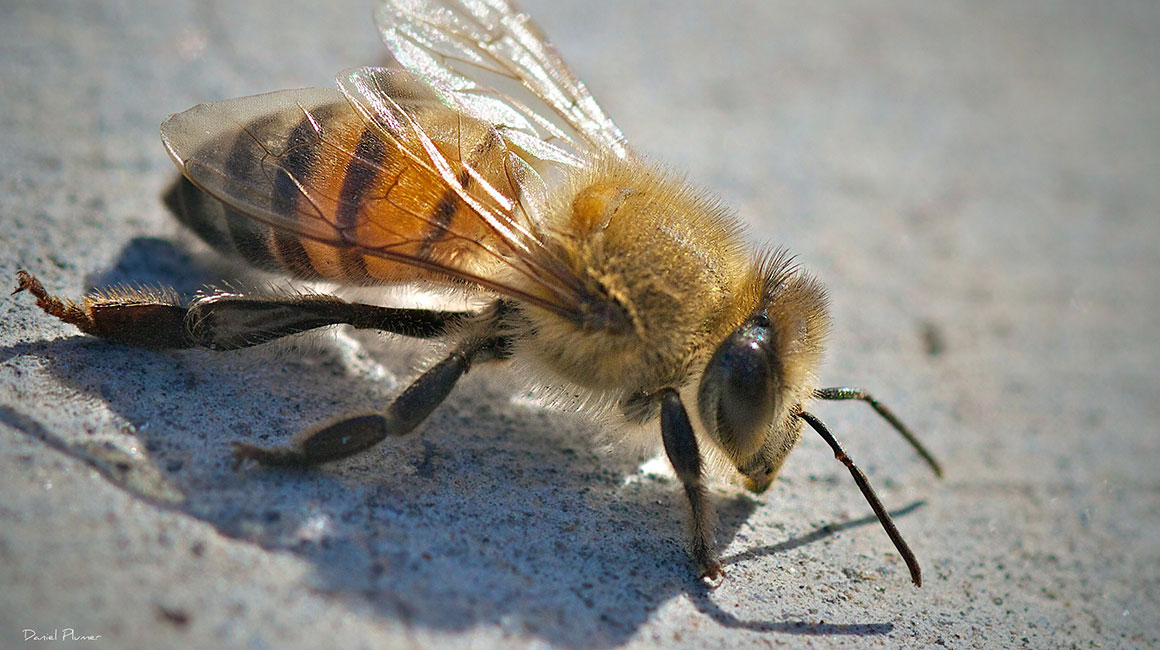

In [7]:
# Data can be converted back to image
array_to_img(img_data)

## Creating an image_dataset_from_directory


In [8]:
# Saving image params as vars for reuse
batch_size = 32
img_height = 128
img_width = 128

In [9]:
# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
    shuffle=True,
    label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
ds

Found 1591 files belonging to 15 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [10]:
# Determine number of batches in dataset
ds_size = len(ds)
ds_size

50

In [11]:
# taking a sample batch to see batch shape
example_batch_imgs,example_batch_y= ds.take(1).get_single_element()
example_batch_imgs.shape

TensorShape([32, 128, 128, 3])

In [12]:
# checking the class names
class_names = ds.class_names
class_names

['Africanized Honey Bees (Killer Bees)',
 'Aphids',
 'Armyworms',
 'Brown Marmorated Stink Bugs',
 'Cabbage Loopers',
 'Citrus Canker',
 'Colorado Potato Beetles',
 'Corn Borers',
 'Corn Earworms',
 'Fall Armyworms',
 'Fruit Flies',
 'Spider Mites',
 'Thrips',
 'Tomato Hornworms',
 'Western Corn Rootworms']

In [13]:
# Saving # of classes for reuse
num_classes = len(class_names)
num_classes

15

In [14]:
# Saving dictionary of integer:string labels
class_dict = dict(zip(range(num_classes), class_names))
class_dict

{0: 'Africanized Honey Bees (Killer Bees)',
 1: 'Aphids',
 2: 'Armyworms',
 3: 'Brown Marmorated Stink Bugs',
 4: 'Cabbage Loopers',
 5: 'Citrus Canker',
 6: 'Colorado Potato Beetles',
 7: 'Corn Borers',
 8: 'Corn Earworms',
 9: 'Fall Armyworms',
 10: 'Fruit Flies',
 11: 'Spider Mites',
 12: 'Thrips',
 13: 'Tomato Hornworms',
 14: 'Western Corn Rootworms'}

In [15]:
# Individual image shape
input_shape = example_batch_imgs[0].shape
input_shape

TensorShape([128, 128, 3])

In [16]:
# Demo Unpacking shape
input_shape = [*input_shape]
input_shape

[128, 128, 3]

## Train, Validation, and Test Split


In [17]:
# Set the ratio of the train, validation, test split
split_train = 0.7
split_val = 0.2
split_test = .1 
# Calculate the number of batches for training and validation data 
n_train_batches =  int(ds_size * split_train)
n_val_batches = int(ds_size * split_val)
print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")



Use 35 batches as training data
Use 10 batches as validation data
The remaining 5 batches will be used as test data.


In [18]:
# Use .take to slice out the number of batches 
train_ds = ds.take(n_train_batches)
# Confirm the length of the training set
len(train_ds)

35

In [19]:
# Skipover the training batches
val_ds = ds.skip(n_train_batches)
# Take the correct number of validation batches
val_ds = val_ds.take(n_val_batches)
# Confirm the length of the validation set
len(val_ds)

10

In [20]:
# Skip over all of the training + validation batches
test_ds = ds.skip(n_train_batches + n_val_batches)
# Confirm the length of the testing data
len(test_ds)

5

In [21]:
# The original (non-take/non-skip) dataset contains the class_names
class_names  = ds.class_names
class_names

['Africanized Honey Bees (Killer Bees)',
 'Aphids',
 'Armyworms',
 'Brown Marmorated Stink Bugs',
 'Cabbage Loopers',
 'Citrus Canker',
 'Colorado Potato Beetles',
 'Corn Borers',
 'Corn Earworms',
 'Fall Armyworms',
 'Fruit Flies',
 'Spider Mites',
 'Thrips',
 'Tomato Hornworms',
 'Western Corn Rootworms']

## Optimize Dataset Performance

In [22]:
# Use autotune to automatically determine best buffer sizes 
AUTOTUNE = tf.data.AUTOTUNE

# ORIGINAL SHUFFLED TRAIN
train_ds = train_ds.cache().shuffle(buffer_size= len(train_ds),
                                   seed=42).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Building the Model


In [23]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=16,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        )) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=32,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        )) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense( len(class_names), activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    return model



In [24]:
# Build the model
model1 = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0

In [27]:
import datetime as dt
# timing
start = dt.datetime.now()
    
# fit the neural network
epochs=10
history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, 
)
    
end = dt.datetime.now()
dur = end-start
print(f"Training time: {dur}")



Epoch 1/10
35/35 [==============================] - 20s 373ms/step - loss: 3.1159 - accuracy: 0.1437 - val_loss: 2.4448 - val_accuracy: 0.2344
Epoch 2/10
35/35 [==============================] - 5s 135ms/step - loss: 2.1034 - accuracy: 0.3777 - val_loss: 2.3110 - val_accuracy: 0.2688
Epoch 3/10
35/35 [==============================] - 5s 138ms/step - loss: 1.7402 - accuracy: 0.5277 - val_loss: 2.0862 - val_accuracy: 0.3688
Epoch 4/10
35/35 [==============================] - 5s 144ms/step - loss: 1.3549 - accuracy: 0.6482 - val_loss: 1.9360 - val_accuracy: 0.4250
Epoch 5/10
35/35 [==============================] - 5s 142ms/step - loss: 1.0289 - accuracy: 0.7429 - val_loss: 1.8761 - val_accuracy: 0.4469
Epoch 6/10
35/35 [==============================] - 5s 141ms/step - loss: 0.7379 - accuracy: 0.8179 - val_loss: 1.8312 - val_accuracy: 0.4875
Epoch 7/10
35/35 [==============================] - 5s 154ms/step - loss: 0.4842 - accuracy: 0.8973 - val_loss: 1.9285 - val_accuracy: 0.4688
Epoch

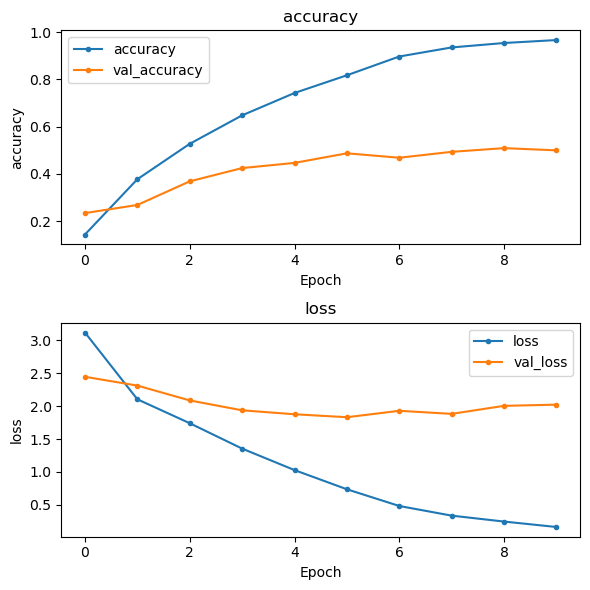


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00        67
           2       0.89      0.88      0.88        73
           3       1.00      1.00      1.00        83
           4       1.00      1.00      1.00        65
           5       1.00      1.00      1.00        69
           6       1.00      1.00      1.00        80
           7       1.00      1.00      1.00        81
           8       1.00      1.00      1.00        78
           9       0.90      0.91      0.90        85
          10       0.99      1.00      0.99        72
          11       1.00      1.00      1.00        82
          12       1.00      0.99      0.99        75
          13       1.00      1.00    

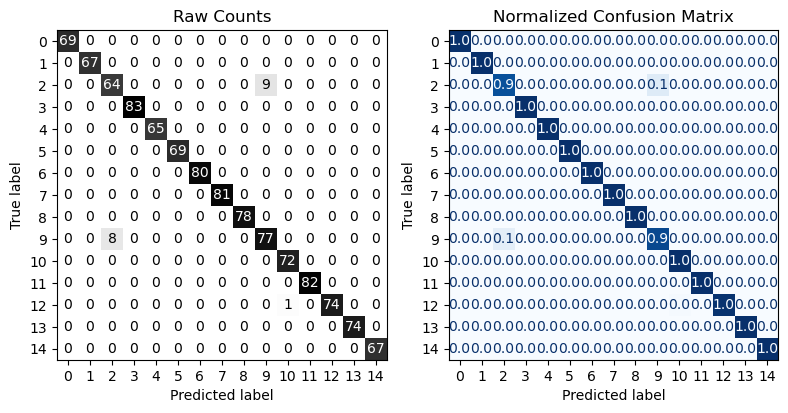


- Evaluating Training Data:
35/35 [==============================] - 2s 47ms/step - loss: 0.0998 - accuracy: 0.9839
{'loss': 0.09980782121419907, 'accuracy': 0.9839285612106323}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.22      0.33         9
           1       0.29      0.25      0.27         8
           2       0.12      0.12      0.12         8
           3       0.57      0.44      0.50         9
           4       0.40      0.55      0.46        11
           5       1.00      0.64      0.78        14
           6       0.67      0.55      0.60        11
           7       0.06      0.20      0.09         5
           8       0.70      0.50      0.58        14
           9       0.38      0.43      0.40         7
          10       0.36      0.56      0.43      

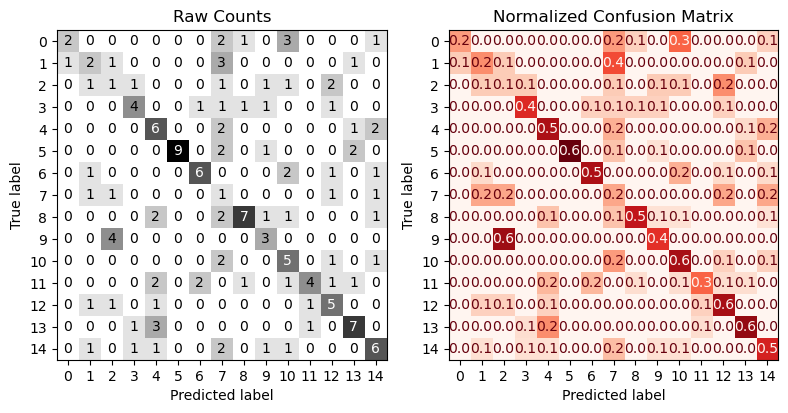


- Evaluating Test Data:
5/5 [==============================] - 0s 60ms/step - loss: 2.3713 - accuracy: 0.4503
{'loss': 2.3712944984436035, 'accuracy': 0.4503311216831207}


In [28]:
# Use evaluation function
af.evaluate_classification_network(
    model1,
    X_train=train_ds,
    X_test=test_ds,
    history=history,
    figsize=(8, 8),
    values_format=".1f",
);

# Tuning CNNs

In [29]:
def build_tune_model_deep(hp):
    model = models.Sequential()
    model.add(layers.Rescaling(1.0 / 255, input_shape=input_shape))
    # Setting hp params and saving as var so they can be used at >1 layer
    n_filters = hp.Int('filters_1',min_value=16, max_value=64, step=16)
    pool_strides = hp.Choice('pool_strides',[1,2])
    
    model.add(layers.Conv2D(n_filters,
                            # Test using larger kernel size (in first Conv layer ONLY)
                            kernel_size= hp.Choice('kernel_size_1',[3,5]),
                            padding='same')
             )
    model.add(layers.MaxPooling2D(2, strides=pool_strides))
    for i in range(hp.Int('n_conv_layers',min_value=1, max_value=3)):
        # Double the number of filters vs. previous layer
        n_filters = n_filters * 2
        model.add(layers.Conv2D(n_filters, kernel_size=3, padding='same'))
        model.add(layers.MaxPooling2D(2, strides=pool_strides))
        
        # model.add(layers.Dropout(hp.Float('dropout_rate',min_value=0.1, max_value=0.5, step=.1)))
    # Final layers
    model.add(layers.Flatten())
    model.add(layers.Dense(n_filters, activation="relu"))
    # Test various dropout strengths
    model.add(layers.Dropout(hp.Float('dropout_rate_dense',min_value=0, max_value=0.5,
                                     step=.1)))
    model.add(layers.Dense(len(class_names), activation="softmax"))
    model.compile(
        optimizer="adam",
        loss='categorical_crossentropy',
        metrics=[
            "accuracy"],
    )
    return model



In [30]:
# Define the tuner
tuner_hb = kt.Hyperband(build_tune_model_deep, objective='val_accuracy',
                        max_epochs=15, overwrite=True, seed=321,) 
# Preivew search summary
tuner_hb.search_space_summary()



NameError: name 'kt' is not defined

In [31]:
def build_model2(hp):
    
    model = models.Sequential(name='TunedModel')
    # Using rescaling layer to scale pixel values
    model.add(layers.Rescaling(1./255, input_shape=input_shape))
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=hp.Int(name='filters_1', 
                           min_value=32, 
                           max_value=64,
                           step=16),  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'))
    
    # Pooling layer
    pool_padding = 'same'
    pool_strides = 2
    model.add(layers.MaxPooling2D(pool_size=2, 
                                  padding=pool_padding,
                                 strides=pool_strides))  # Size of pooling


    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=hp.Int(name='filters_2', 
                           min_value=32, 
                           max_value=64,
                           step=32),  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same')) 

    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2, 
                                  padding=pool_padding,
                                 strides=pool_strides))  # Size of pooling




    # if hp.Boolean('batch_normalization'):
    #     model.add(layers.BatchNormalization())
        
    
    # Flattening layer
    model.add(layers.Flatten())

    # Tune n_dense layers
    n_layers = hp.Int('n_hidden_dense_layers', 
                          min_value=1,
                          max_value=3)
    n_units = hp.Float('n_units_dense',min_value=128,max_value=1024,step=128,)
    dropout_rate = hp.Float("drop_rate",min_value=0.0,
                                         max_value=0.5, step=0.1)
    for n in range(n_layers):
        model.add(layers.Dense(n_units, activation='relu'))       
        # Add dropout
        model.add(layers.Dropout(dropout_rate))
    
        
        
    # Output layer
    model.add(
        layers.Dense(len(class_names), activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?

    # ## Tuning for Optimizer (classes)
    # chosen_optimizer = hp.Choice('optimizer',['adam','nadam','rmsprop'])
    # if chosen_optimizer=='adam':
    #     optimizer = tf.keras.optimizers.legacy.Adam()
    # elif chosen_optimizer=='nadam':
    #     optimizer =tf.keras.optimizers.legacy.Nadam()
    # elif chosen_optimizer=='rmsprop':
    #     optimizer = tf.keras.optimizers.legacy.RMSprop()

    

    ## Compile model   
    lr = hp.Float('learning_rate',min_value=.0001, max_value=10, step=10, sampling='log')
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy',])
    
    model.summary()
    return model

In [33]:
def get_callbacks( ):
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,
                                                      monitor='val_accuracy')
    
    return [early_stopping]

In [33]:
import keras_tuner as kt
from keras_tuner import HyperParameters as hp
import os

# Creating the directory for kerastuner's results
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [37]:
#hyperband allows for callbacks
tuner_hb = kt.Hyperband(build_model2, objective='val_accuracy',
                        max_epochs=20, overwrite=True, directory=folder, 
                project_name='tuning-cnn1',)
tuner_hb.search_space_summary()

Model: "TunedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0

In [38]:
tuner_hb.search(train_ds,validation_data=val_ds, epochs=20)#, callbacks=get_callbacks())
tuner_hb.results_summary()

Trial 30 Complete [00h 06m 58s]
val_accuracy: 0.09375

Best val_accuracy So Far: 0.559374988079071
Total elapsed time: 00h 59m 48s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in KerasTuner/tuning-cnn1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0027 summary
Hyperparameters:
filters_1: 32
filters_2: 64
n_hidden_dense_layers: 3
n_units_dense: 768.0
drop_rate: 0.0
learning_rate: 0.0001
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.559374988079071

Trial 0026 summary
Hyperparameters:
filters_1: 48
filters_2: 32
n_hidden_dense_layers: 3
n_units_dense: 768.0
drop_rate: 0.1
learning_rate: 0.0001
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.5562499761581421

Trial 0017 summary
Hyperparameters:
filters_1: 32
filters_2: 64
n_hidden_dense_layers: 2
n_units_dense: 512.0
drop_rate: 0.2
learning_rate: 0.0001
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2

In [39]:
best_hps = tuner_hb.get_best_hyperparameters()[0]
print(best_hps.values)

{'filters_1': 32, 'filters_2': 64, 'n_hidden_dense_layers': 3, 'n_units_dense': 768.0, 'drop_rate': 0.0, 'learning_rate': 0.0001, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [40]:
best_model = tuner_hb.get_best_models()[0]
best_model.summary()

Model: "TunedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00        67
           2       1.00      0.77      0.87        73
           3       1.00      1.00      1.00        83
           4       1.00      1.00      1.00        65
           5       1.00      1.00      1.00        69
           6       1.00      1.00      1.00        80
           7       1.00      1.00      1.00        81
           8       1.00      1.00      1.00        78
           9       0.83      1.00      0.91        85
          10       1.00      1.00      1.00        72
          11       1.00      1.00      1.00        82
          12       1.00      1.00      1.00        75
          13       1.00      1.00    

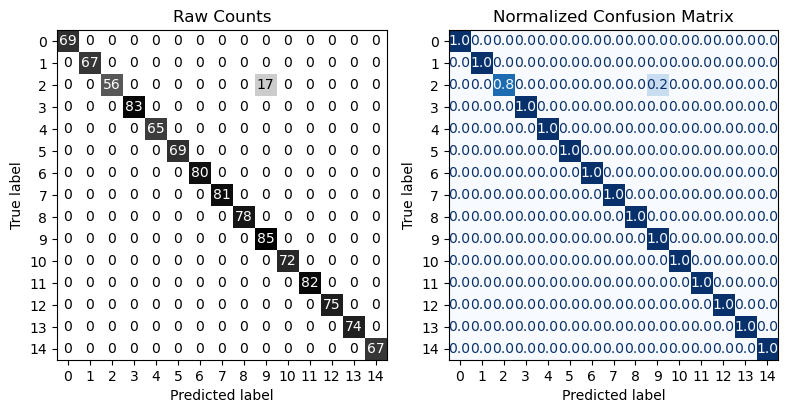


- Evaluating Training Data:
35/35 [==============================] - 4s 100ms/step - loss: 0.0591 - accuracy: 0.9848
{'loss': 0.05914376676082611, 'accuracy': 0.9848214387893677}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.40      0.22      0.29         9
           1       0.14      0.12      0.13         8
           2       0.20      0.12      0.15         8
           3       0.40      0.44      0.42         9
           4       0.58      0.64      0.61        11
           5       0.71      0.71      0.71        14
           6       0.86      0.55      0.67        11
           7       0.14      0.20      0.17         5
           8       0.82      0.64      0.72        14
           9       0.16      0.43      0.23         7
          10       0.56      0.56      0.56     

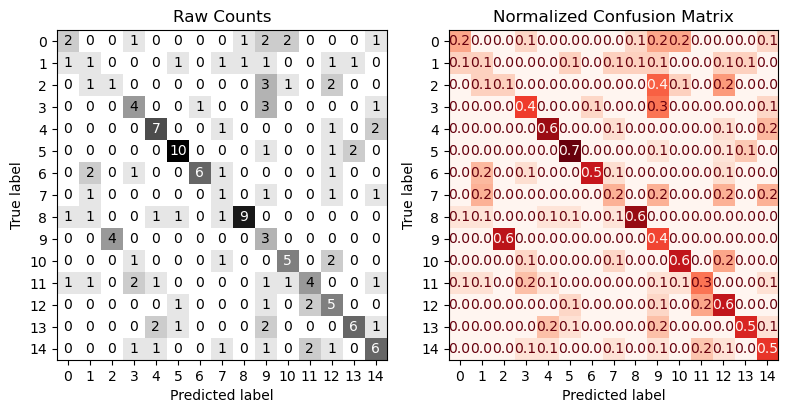


- Evaluating Test Data:
5/5 [==============================] - 1s 114ms/step - loss: 2.3554 - accuracy: 0.4636
{'loss': 2.3554391860961914, 'accuracy': 0.46357616782188416}


In [42]:
af.evaluate_classification_network(best_model,X_train=train_ds, X_test=test_ds,
                                   figsize=(8,12), values_format='.1f'
);

# Data Augmentation (Practice)


In [25]:
# Define data augmentation layer
data_augmentation = models.Sequential(
    [
        # Randomly flip image orientation
        layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape),
        # Randomly rotate the image (+ values means rotating counter clock-wise)
        layers.RandomRotation(0.15),
        layers.RandomZoom(
            height_factor=(-0.2, 0.2),  # Zoom in or out up to 20% (height)
            width_factor=(-0.2, 0.2),  # Zoom in or out up to 20% (width)
        ),
    ]
)
data_augmentation

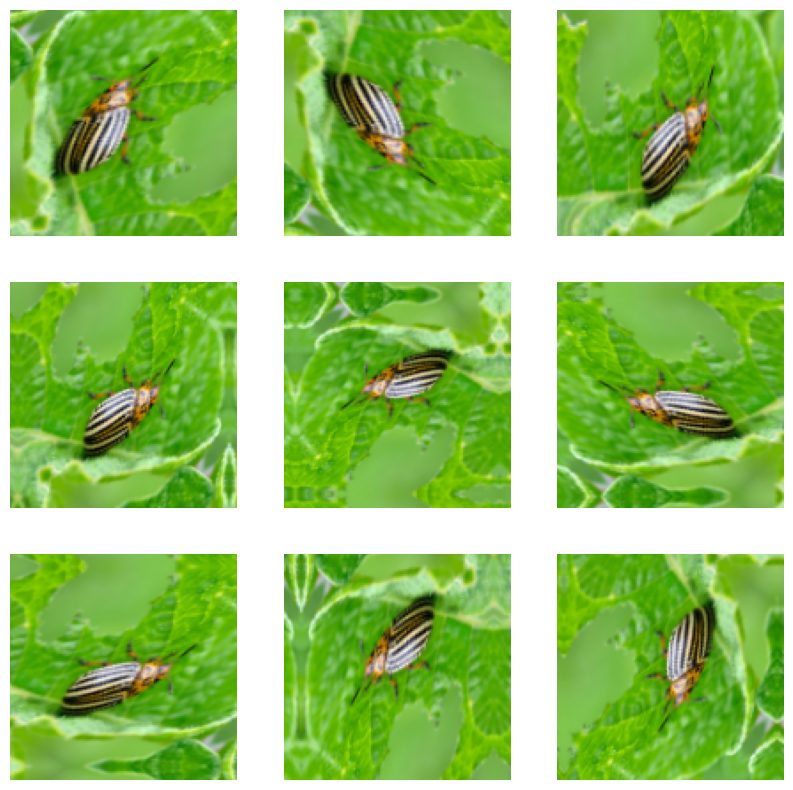

In [28]:
# Explore effects of data augmentation
fig, axes = plt.subplots(figsize=(10, 10), nrows=3, ncols=3)
axes = axes.flatten()

for images, _ in train_ds.take(1):
  for i,ax in enumerate(axes):#range(9):
    augmented_images = data_augmentation(images)
    ax.imshow(augmented_images[1].numpy().astype("uint8"), cmap='gray')
    ax.axis("off")

In [30]:
def build_model_dual_conv_augmented():

    model = models.Sequential()
    # Using rescaling layer to scale pixel values
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)
    # Add data Augmentation here
    model.add(data_augmentation)
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=64,  # How many filters you want to use
            kernel_size= 3,  # size of each filter
            input_shape=input_shape,
            padding= 'same'
        ))  
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters= 64,  # How many filters you want to use
            kernel_size= 3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        )) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling


    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters= 64,  # How many filters you want to use
            kernel_size= 3,  # size of each filter
            input_shape=input_shape,
            padding= 'same'
        )) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(len(class_names), activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?
    
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    model.summary()
    return model

In [31]:
model1_aug= build_model_dual_conv_augmented()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        36928     
                                                      

In [29]:
def get_callbacks(patience=3,monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, 
                                                  monitor=monitor)
    return [early_stop]

In [36]:
# Fit the model
epochs = 25
history = model1_aug.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs, callbacks = get_callbacks(patience = 10))

Epoch 1/25
35/35 [==============================] - 69s 2s/step - loss: 3.3454 - accuracy: 0.0857 - val_loss: 2.7699 - val_accuracy: 0.1219
Epoch 2/25
35/35 [==============================] - 55s 2s/step - loss: 2.5623 - accuracy: 0.1554 - val_loss: 2.6324 - val_accuracy: 0.1594
Epoch 3/25
35/35 [==============================] - 51s 1s/step - loss: 2.4978 - accuracy: 0.1821 - val_loss: 2.5019 - val_accuracy: 0.2000
Epoch 4/25
35/35 [==============================] - 50s 1s/step - loss: 2.4925 - accuracy: 0.1813 - val_loss: 2.5574 - val_accuracy: 0.1969
Epoch 5/25
35/35 [==============================] - 50s 1s/step - loss: 2.4232 - accuracy: 0.2143 - val_loss: 2.6079 - val_accuracy: 0.1969
Epoch 6/25
35/35 [==============================] - 51s 1s/step - loss: 2.3962 - accuracy: 0.2062 - val_loss: 2.5283 - val_accuracy: 0.1750
Epoch 7/25
35/35 [==============================] - 1892s 56s/step - loss: 2.4056 - accuracy: 0.2259 - val_loss: 2.5411 - val_accuracy: 0.2125
Epoch 8/25
35/35 

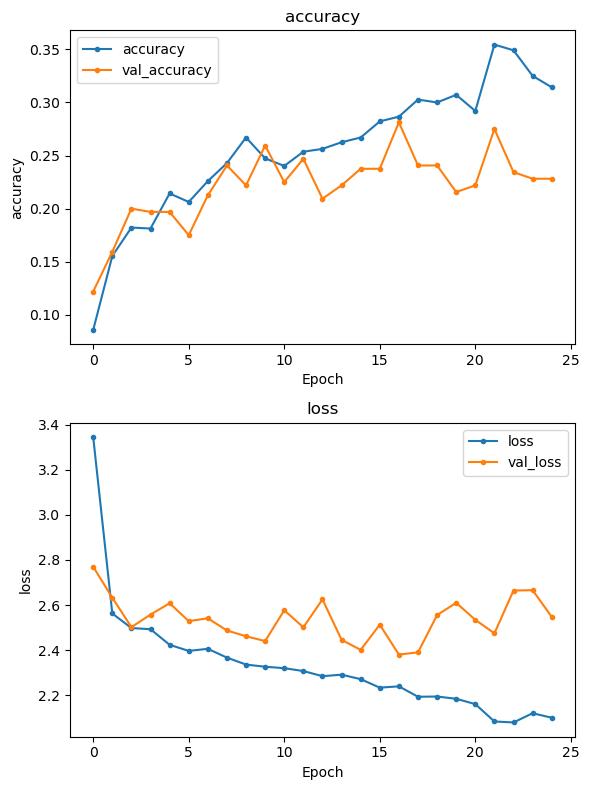

In [39]:
af.plot_history(history);


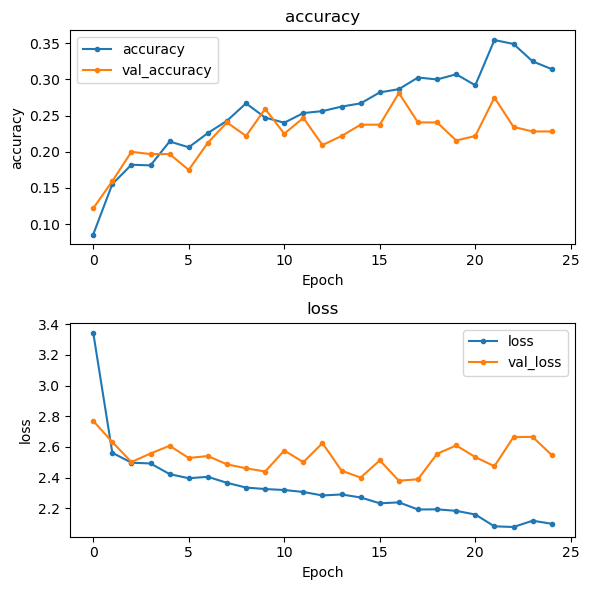


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        69
           1       0.33      0.04      0.08        67
           2       0.12      0.29      0.17        73
           3       0.20      0.92      0.33        83
           4       0.32      0.55      0.41        65
           5       0.76      0.28      0.40        69
           6       0.55      0.40      0.46        80
           7       0.52      0.32      0.40        81
           8       0.38      0.23      0.29        78
           9       0.20      0.22      0.21        85
          10       0.57      0.38      0.45        72
          11       0.36      0.06      0.10        82
          12       0.42      0.27      0.33        75
          13       0.66      0.31    

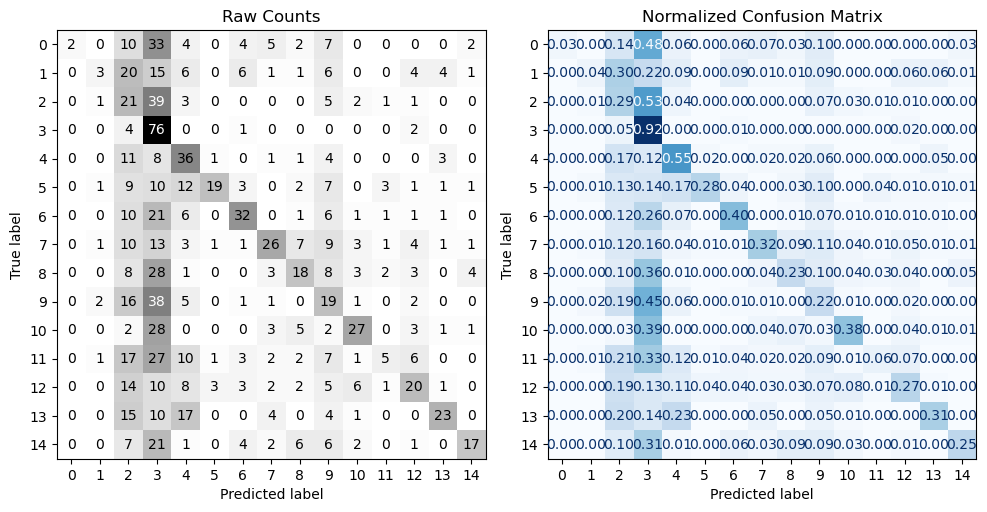


- Evaluating Training Data:
35/35 [==============================] - 12s 342ms/step - loss: 2.3305 - accuracy: 0.3071
{'loss': 2.330517053604126, 'accuracy': 0.30714285373687744}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         8
           2       0.04      0.12      0.06         8
           3       0.14      0.78      0.24         9
           4       0.40      0.73      0.52        11
           5       0.67      0.29      0.40        14
           6       0.30      0.27      0.29        11
           7       0.00      0.00      0.00         5
           8       0.43      0.21      0.29        14
           9       0.00      0.00      0.00         7
          10       0.62      0.56      0.59     

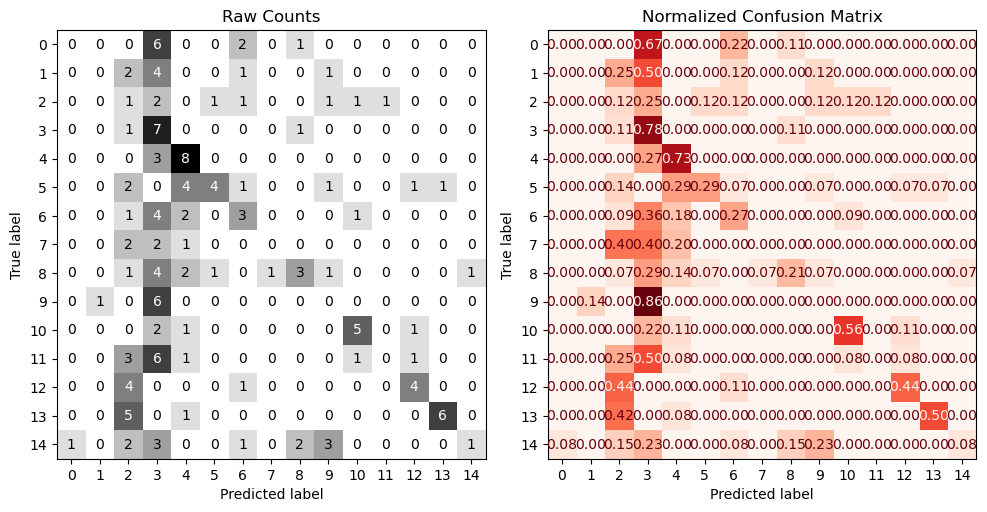


- Evaluating Test Data:
5/5 [==============================] - 2s 330ms/step - loss: 2.6090 - accuracy: 0.2781
{'loss': 2.6089651584625244, 'accuracy': 0.2781457006931305}


In [42]:
# Call custom function to evaluate
af.evaluate_classification_network(model1_aug, X_train = train_ds, X_test = test_ds, figsize = (10,14), history = history);

# Transfer Learning


In [25]:
# Download base
vgg16_base = tf.keras.applications.VGG16(include_top=False,
                                         weights='imagenet', 
                                        input_shape=input_shape
                                        )
# Prevent layers from base_model from changing 
vgg16_base.trainable = False

In [27]:
def build_transfer_model_vgg(pretrained_base,show_summary=True):
        
    model = models.Sequential()
    # Add input layer
    model.add( tf.keras.layers.Input(shape=input_shape))

    # Define lambda preprocessing layer
    lambda_layer = tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input, 
                                      name='preprocess_input')
    # Addd lambda layer
    model.add(lambda_layer)
    
    # Add transfer learning model specified when function is called
    model.add(pretrained_base)
    
    # Flattening layer
    model.add(layers.Flatten())
    

    # Adding a Hidden Dense Layer    
    model.add(layers.Dense(256, activation="relu") )

    model.add(layers.Dropout(.1))
    
    # Output layer
    model.add(
        layers.Dense(len(class_names), activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?
    
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    if show_summary:
        model.summary()
    return model

In [30]:
# Run Build Function with pretrained model and processing layer
model = build_transfer_model_vgg(vgg16_base)

# fit and evaluate
history = model.fit(train_ds, validation_data=val_ds,epochs=25, 
                    callbacks=get_callbacks())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 128, 128, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 15)                3855      
                                                                 
Total params: 16,815,951
Trainable params: 2,101,263
N

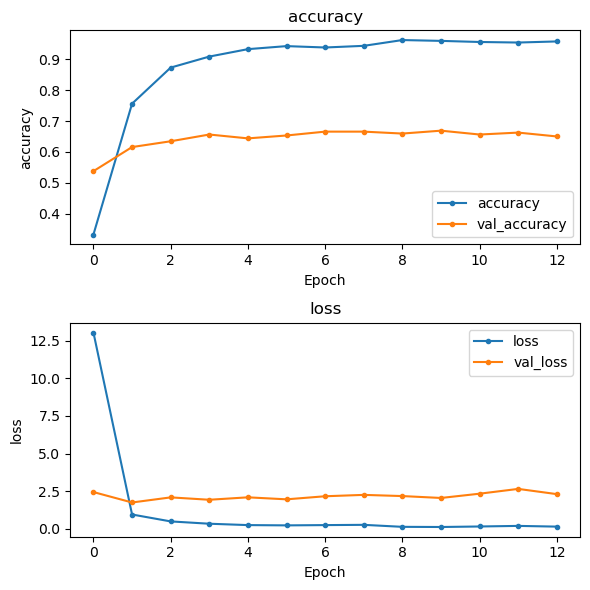


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00        67
           2       0.91      0.85      0.88        73
           3       1.00      0.99      0.99        83
           4       1.00      1.00      1.00        65
           5       1.00      1.00      1.00        69
           6       0.99      1.00      0.99        80
           7       1.00      1.00      1.00        81
           8       1.00      1.00      1.00        78
           9       0.88      0.93      0.90        85
          10       1.00      1.00      1.00        72
          11       0.99      1.00      0.99        82
          12       1.00      1.00      1.00        75
          13       1.00      1.00    

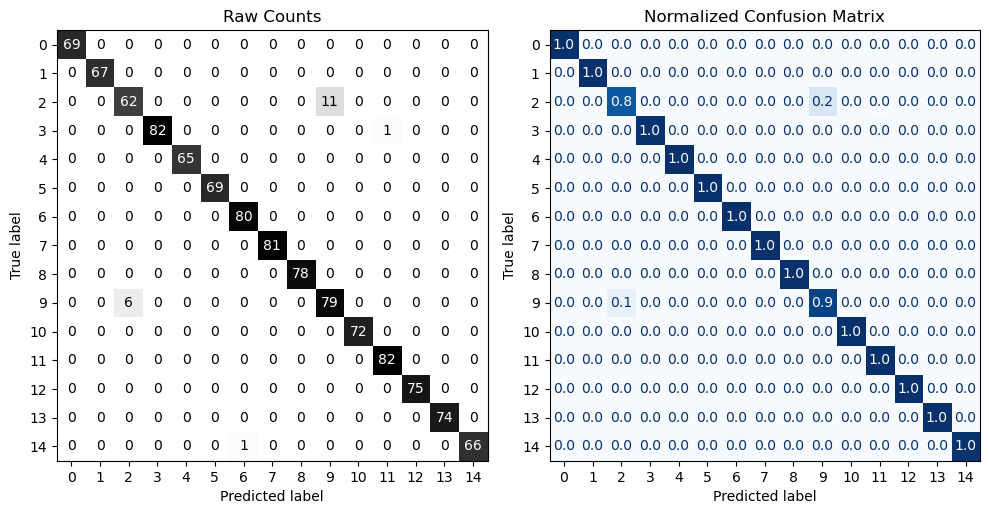


- Evaluating Training Data:
35/35 [==============================] - 60s 2s/step - loss: 0.0693 - accuracy: 0.9830
{'loss': 0.0692899227142334, 'accuracy': 0.9830357432365417}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       1.00      0.38      0.55         8
           2       0.38      0.38      0.38         8
           3       0.86      0.67      0.75         9
           4       0.67      0.73      0.70        11
           5       0.83      0.71      0.77        14
           6       0.85      1.00      0.92        11
           7       0.43      0.60      0.50         5
           8       0.53      0.57      0.55        14
           9       0.50      0.43      0.46         7
          10       0.80      0.89      0.84        

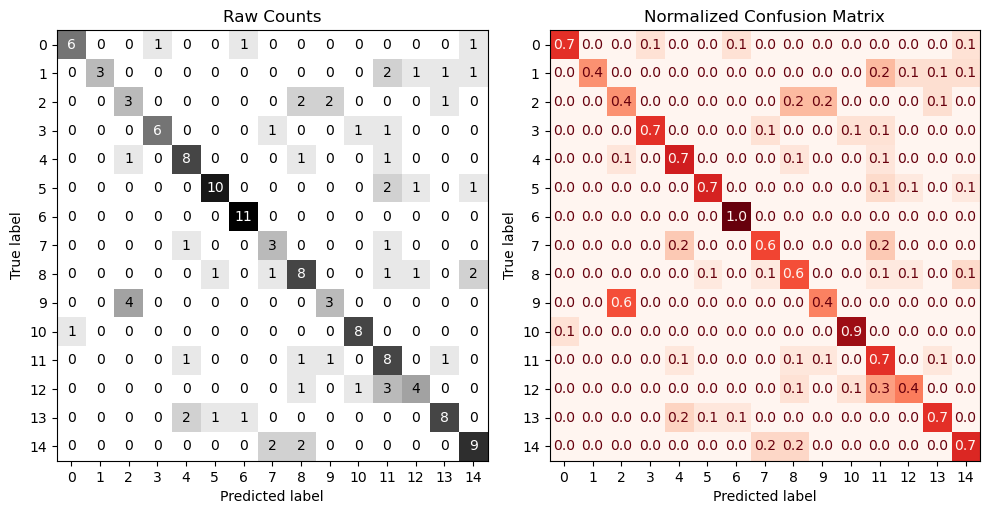


- Evaluating Test Data:
5/5 [==============================] - 8s 2s/step - loss: 2.1321 - accuracy: 0.6490
{'loss': 2.132089853286743, 'accuracy': 0.6490066051483154}


In [32]:
af.evaluate_classification_network(model,X_train=train_ds,
                                   X_test=test_ds,history=history,
                                   figsize=(10,12), 
                                   values_format=".1f");

In [34]:
# saving the best model without optimizer
model_fname = 'BestModels/transfer-learning-insects-acc75-no-opt.keras'
model.save(model_fname,include_optimizer=False)